## Imports

In [26]:
!pip install opencv-python seaborn

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
import zipfile
from pathlib import Path

# print("TensorFlow version:", tf.__version__)
# print("GPU Available:", tf.config.list_physical_devices('GPU'))


[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Config

In [34]:
IMAGE_SIZE = (32, 32)
BATCH_SIZE = 32
EPOCHS = 30
VALIDATION_SPLIT = 0.2
DATA_PATH = "src\dataset"

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\rafae\AppData\Local\Temp\ipykernel_28440\2141204357.py:5: SyntaxWarning: invalid escape sequence '\d'
  DATA_PATH = "src\dataset"


## Testing Dataset

In [35]:
def explore_dataset(data_path):
    print(f"Explorando dataset em: {data_path}")

    if not os.path.exists(data_path):
        print("Dataset não encontrado!")
        return

    for root, dirs, files in os.walk(data_path):
        level = root.replace(data_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... e mais {len(files) - 5} arquivos")

explore_dataset(DATA_PATH)

Explorando dataset em: src\dataset
dataset/
  Negative/
    00001.jpg
    00002.jpg
    00003.jpg
    00004.jpg
    00005.jpg
    ... e mais 19995 arquivos
  Positive/
    00001.jpg
    00002.jpg
    00003.jpg
    00004.jpg
    00005.jpg
    ... e mais 19995 arquivos


## Preprocess Dataset

In [36]:
def preprocess_image(image_path, target_size=IMAGE_SIZE):
    """
    Pré-processa uma imagem individual
    """
    # Carregar imagem
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Não foi possível carregar a imagem: {image_path}")

    # Converter BGR para RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Remoção de ruído usando filtro Gaussiano
    # JUSTIFICATIVA: Remove ruído preservando bordas importantes para detecção de rachaduras
    image_denoised = cv2.GaussianBlur(image_rgb, (5, 5), 0)

    # Redimensionar para tamanho padrão
    image_resized = cv2.resize(image_denoised, target_size)

    # Normalização (0-1)
    image_normalized = image_resized / 255.0

    return image_normalized

def show_preprocessing_steps(image_path):
    """
    Demonstra as etapas de pré-processamento
    """
    # Carregar imagem original
    original = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Aplicar pré-processamento
    denoised = cv2.GaussianBlur(original_rgb, (5, 5), 0)
    resized = cv2.resize(denoised, IMAGE_SIZE)
    normalized = resized / 255.0

    # Plotar resultados
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(original_rgb)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(denoised)
    axes[1].set_title("Filtro Gaussiano\n(Remoção de Ruído)")
    axes[1].axis("off")

    axes[2].imshow(resized)
    axes[2].set_title(f"Redimensionada\n{IMAGE_SIZE}")
    axes[2].axis("off")

    axes[3].imshow(normalized)
    axes[3].set_title("Normalizada (0-1)")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

## Load Samples

In [56]:
def load_sample_images(data_path, n_samples=5):
    """
    Carrega amostras do dataset para exploração
    """
    positive_path = os.path.join(data_path, "positives")
    negative_path = os.path.join(data_path, "negatives")

    # Verificar se os diretórios existem
    if not os.path.exists(positive_path):
        print("Diretório 'Positive' não encontrado. Procurando estrutura alternativa...")
        # Procurar por estrutura alternativa
        for root, dirs, files in os.walk(data_path):
            if any('positive' in d.lower() or 'crack' in d.lower() for d in dirs):
                positive_path = os.path.join(root, [d for d in dirs if 'positive' in d.lower() or 'crack' in d.lower()][0])
                break

    if not os.path.exists(negative_path):
        print("Diretório 'Negative' não encontrado. Procurando estrutura alternativa...")
        for root, dirs, files in os.walk(data_path):
            if any('negative' in d.lower() or 'no' in d.lower() for d in dirs):
                negative_path = os.path.join(root, [d for d in dirs if 'negative' in d.lower() or 'no' in d.lower()][0])
                break

    print(f"Positive path: {positive_path}")
    print(f"Negative path: {negative_path}")

    # Carregar amostras
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))

    # Imagens com rachadura
    if os.path.exists(positive_path):
        positive_files = [f for f in os.listdir(positive_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for i in range(min(n_samples, len(positive_files))):
            img_path = os.path.join(positive_path, positive_files[i])
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[0, i].imshow(img_rgb)
            axes[0, i].set_title(f"COM RACHADURA\n{positive_files[i]}")
            axes[0, i].axis("off")

    # Imagens sem rachadura
    if os.path.exists(negative_path):
        negative_files = [f for f in os.listdir(negative_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for i in range(min(n_samples, len(negative_files))):
            img_path = os.path.join(negative_path, negative_files[i])
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[1, i].imshow(img_rgb)
            axes[1, i].set_title(f"SEM RACHADURA\n{negative_files[i]}")
            axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

## CNN Model

In [63]:
def create_cnn_model(input_shape):
    """
    Cria modelo CNN para classificação binária
    """
    
    model = models.Sequential([
        Conv2D(filters=6, kernel_size=(5, 5), padding='valid', activation='tanh', input_shape=input_shape),
        AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'),
        Conv2D(filters=16, kernel_size=(5, 5),  padding='valid', activation='tanh'),
        AveragePooling2D(pool_size=(2, 2), strides=2,  padding='valid'),
        Flatten(),
        Dense(units=120, activation='tanh'),
        Dense(units=84, activation='tanh'),
        Dense(units=1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Criar e visualizar modelo

## Load Dataset

In [ ]:
def load_full_dataset(data_path, sample_size=None):
    """
    Carrega o dataset completo
    """
    print("Carregando dataset...")

    # Procurar diretórios positivos e negativos (case-insensitive, plural/singular)
    positive_path = os.path.join(data_path, "Positive")
    negative_path = os.path.join(data_path, "Negative")

    # Verificar estrutura alternativa se necessário
    if not os.path.exists(positive_path):
        for root, dirs, files in os.walk(data_path):
            for d in dirs:
                if 'positive' in d.lower() or 'crack' in d.lower():
                    positive_path = os.path.join(root, d)
                    break

    if not os.path.exists(negative_path):
        for root, dirs, files in os.walk(data_path):
            for d in dirs:
                if 'negative' in d.lower() or 'no' in d.lower():
                    negative_path = os.path.join(root, d)
                    break

    print(f"Positive path found: {positive_path} (exists: {os.path.exists(positive_path)})")
    print(f"Negative path found: {negative_path} (exists: {os.path.exists(negative_path)})")

    if not os.path.exists(positive_path):
        raise ValueError(f"Diretório de imagens positivas não encontrado: {positive_path}")
    if not os.path.exists(negative_path):
        raise ValueError(f"Diretório de imagens negativas não encontrado: {negative_path}")

    images = []
    labels = []

    # Carregar imagens positivas (com rachaduras)
    if os.path.exists(positive_path):
        positive_files = [f for f in os.listdir(positive_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if sample_size:
            positive_files = positive_files[:sample_size//2]

        print(f"Carregando {len(positive_files)} imagens COM rachadura...")
        for i, filename in enumerate(positive_files):
            if i % 1000 == 0:
                print(f"Processadas {i} imagens positivas...")

            img_path = os.path.join(positive_path, filename)
            try:
                img = preprocess_image(img_path)
                images.append(img)
                labels.append(1)  # Com rachadura
            except Exception as e:
                print(f"Erro ao processar {filename}: {e}")

    # Carregar imagens negativas (sem rachaduras)
    if os.path.exists(negative_path):
        negative_files = [f for f in os.listdir(negative_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if sample_size:
            negative_files = negative_files[:sample_size//2]

        print(f"Carregando {len(negative_files)} imagens SEM rachadura...")
        for i, filename in enumerate(negative_files):
            if i % 1000 == 0:
                print(f"Processadas {i} imagens negativas...")

            img_path = os.path.join(negative_path, filename)
            try:
                img = preprocess_image(img_path)
                images.append(img)
                labels.append(0)  # Sem rachadura
            except Exception as e:
                print(f"Erro ao processar {filename}: {e}")

    if not images:
        raise ValueError("Nenhuma imagem foi carregada. Verifique o caminho do dataset.")

    X = np.array(images)
    y = np.array(labels)

    print(f"\nDataset carregado com sucesso!")
    print(f"Total de imagens: {len(X)}")
    print(f"Imagens com rachadura: {np.sum(y)}")
    print(f"Imagens sem rachadura: {len(y) - np.sum(y)}")
    print(f"Shape das imagens: {X.shape}")
    print(f"Shape dos labels: {y.shape}")

    return X, y

X, y = load_full_dataset(DATA_PATH, sample_size=10000)  # Para teste rápido
# X, y = load_full_dataset(DATA_PATH)  # Para dataset completo

Carregando dataset...
Positive path found: src\dataset\Positive (exists: True)
Negative path found: src\dataset\Negative (exists: True)
Carregando 5000 imagens COM rachadura...
Processadas 0 imagens positivas...
Processadas 1000 imagens positivas...
Processadas 2000 imagens positivas...
Processadas 3000 imagens positivas...
Processadas 4000 imagens positivas...
Carregando 5000 imagens SEM rachadura...
Processadas 0 imagens negativas...
Processadas 1000 imagens negativas...
Processadas 2000 imagens negativas...
Processadas 3000 imagens negativas...
Processadas 4000 imagens negativas...

Dataset carregado com sucesso!
Total de imagens: 10000
Imagens com rachadura: 5000
Imagens sem rachadura: 5000
Shape das imagens: (10000, 32, 32, 3)
Shape dos labels: (10000,)


# Training and Testing

In [64]:
def prepare_data(X, y, test_size=0.2):
    """
    Prepara dados para treinamento
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    print(f"Conjunto de treino: {len(X_train)} imagens")
    print(f"Conjunto de teste: {len(X_test)} imagens")
    print(f"Distribuição treino - Com rachadura: {np.sum(y_train)}, Sem rachadura: {len(y_train) - np.sum(y_train)}")
    print(f"Distribuição teste - Com rachadura: {np.sum(y_test)}, Sem rachadura: {len(y_test) - np.sum(y_test)}")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data(X, y)
model = create_cnn_model(X_train.shape[1:])

Conjunto de treino: 8000 imagens
Conjunto de teste: 2000 imagens
Distribuição treino - Com rachadura: 4000, Sem rachadura: 4000
Distribuição teste - Com rachadura: 1000, Sem rachadura: 1000


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Data Augumentation

In [65]:
def create_data_generators(X_train, y_train, batch_size=BATCH_SIZE):
    """
    Cria geradores de dados com augmentation
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=VALIDATION_SPLIT
    )

    train_generator = datagen.flow(
        X_train, y_train,
        batch_size=batch_size,
        subset='training',
        seed=42
    )

    validation_generator = datagen.flow(
        X_train, y_train,
        batch_size=batch_size,
        subset='validation',
        seed=42
    )

    return train_generator, validation_generator

## Training

In [66]:
def train_model(model, X_train, y_train, use_augmentation=True):
    """
    Treina o modelo
    """
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

    if use_augmentation:
        # Treinamento com data augmentation
        train_gen, val_gen = create_data_generators(X_train, y_train)

        history = model.fit(
            train_gen,
            epochs=EPOCHS,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=1
        )
    else:
        # Treinamento sem augmentation
        history = model.fit(
            X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_split=VALIDATION_SPLIT,
            callbacks=callbacks,
            verbose=1
        )

    return history

print("Iniciando treinamento...")
history = train_model(model, X_train, y_train, use_augmentation=True)

Iniciando treinamento...
Epoch 1/30


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6206 - loss: 0.6557 - precision: 0.6448 - recall: 0.5418 - val_accuracy: 0.8075 - val_loss: 0.4881 - val_precision: 0.9372 - val_recall: 0.6638 - learning_rate: 0.0010
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7953 - loss: 0.4831 - precision: 0.8307 - recall: 0.7434 - val_accuracy: 0.8313 - val_loss: 0.4308 - val_precision: 0.8738 - val_recall: 0.7787 - learning_rate: 0.0010
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7998 - loss: 0.4555 - precision: 0.8543 - recall: 0.7180 - val_accuracy: 0.8575 - val_loss: 0.3249 - val_precision: 0.9546 - val_recall: 0.7540 - learning_rate: 0.0010
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8646 - loss: 0.3378 - precision: 0.9210 - recall: 0.7960 - val_accuracy: 0.8950 - val_loss: 0.2798 - val_precision: 0.8933 - val_recall: 0.8999 - learning_rate: 0.0010
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8916

## Model Review

Fazendo predições...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

=== RESULTADOS DA AVALIAÇÃO ===
Acurácia no conjunto de teste: 0.9760 (97.60%)
✅ APROVADO: Acurácia >= 80%

=== RELATÓRIO DE CLASSIFICAÇÃO ===
               precision    recall  f1-score   support

Sem Rachadura       0.98      0.97      0.98      1000
Com Rachadura       0.97      0.98      0.98      1000

     accuracy                           0.98      2000
    macro avg       0.98      0.98      0.98      2000
 weighted avg       0.98      0.98      0.98      2000



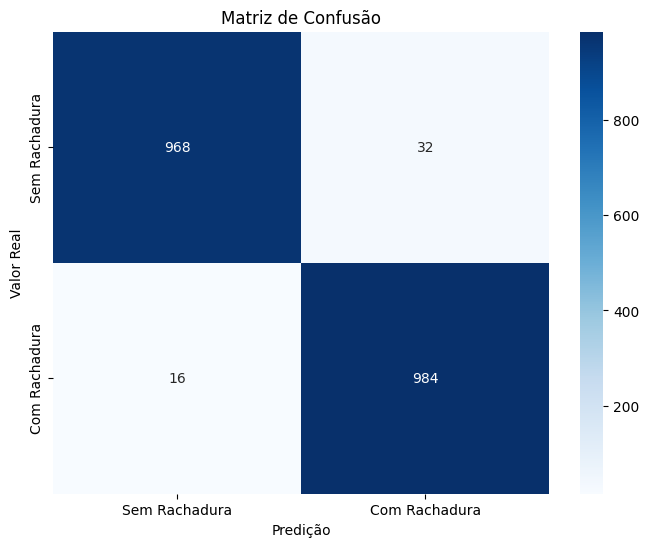

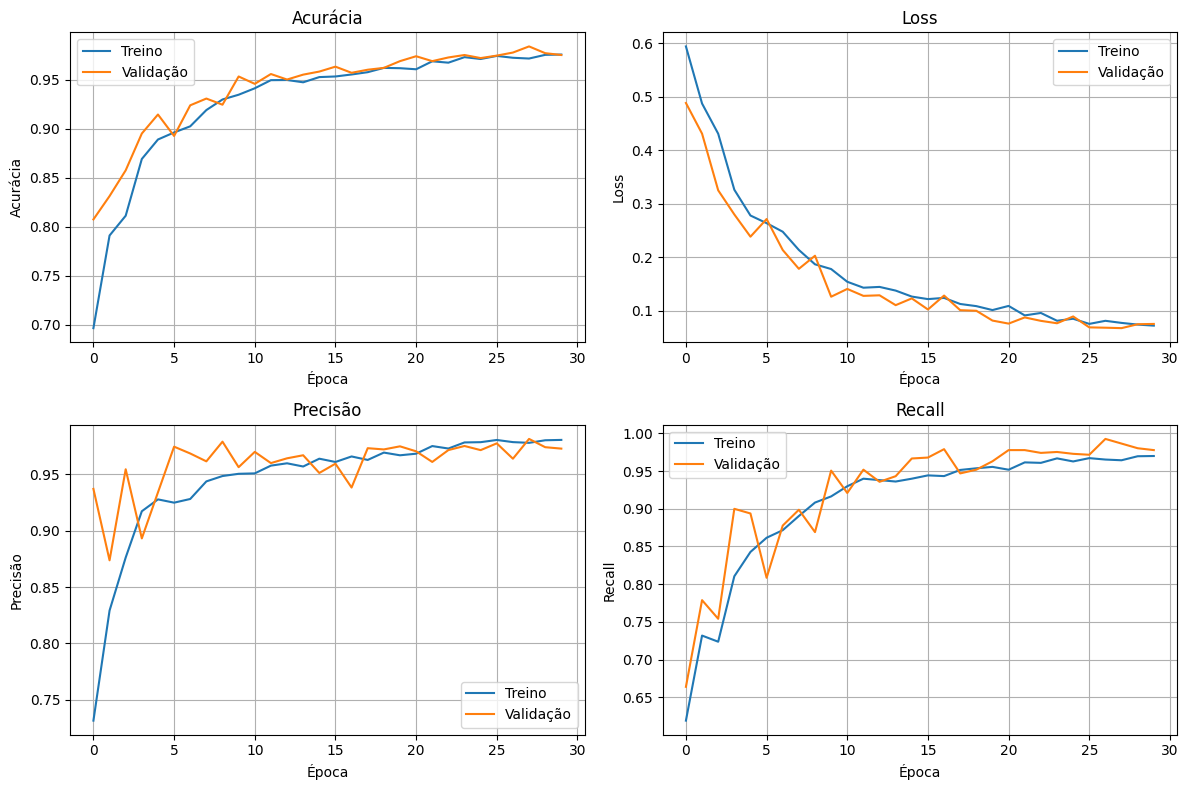

In [67]:
def evaluate_model(model, X_test, y_test, history):
    """
    Avalia o modelo treinado
    """
    # Predições
    print("Fazendo predições...")
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n=== RESULTADOS DA AVALIAÇÃO ===")
    print(f"Acurácia no conjunto de teste: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Verificar se atende ao requisito de 80%
    if accuracy >= 0.8:
        print("✅ APROVADO: Acurácia >= 80%")
    else:
        print("❌ REPROVADO: Acurácia < 80%")

    # Relatório detalhado
    print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
    print(classification_report(y_test, y_pred,
                              target_names=['Sem Rachadura', 'Com Rachadura']))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Sem Rachadura', 'Com Rachadura'],
                yticklabels=['Sem Rachadura', 'Com Rachadura'])
    plt.title('Matriz de Confusão')
    plt.ylabel('Valor Real')
    plt.xlabel('Predição')
    plt.show()

    # Plotar histórico de treinamento
    plot_training_history(history)

    return accuracy, y_pred_proba

def plot_training_history(history):
    """
    Plota histórico de treinamento
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Acurácia
    axes[0, 0].plot(history.history['accuracy'], label='Treino')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validação')
    axes[0, 0].set_title('Acurácia')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Acurácia')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Treino')
    axes[0, 1].plot(history.history['val_loss'], label='Validação')
    axes[0, 1].set_title('Loss')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precisão
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Treino')
        axes[1, 0].plot(history.history['val_precision'], label='Validação')
        axes[1, 0].set_title('Precisão')
        axes[1, 0].set_xlabel('Época')
        axes[1, 0].set_ylabel('Precisão')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # Recall
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Treino')
        axes[1, 1].plot(history.history['val_recall'], label='Validação')
        axes[1, 1].set_title('Recall')
        axes[1, 1].set_xlabel('Época')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Avaliar modelo (descomente após treinar)
accuracy, predictions = evaluate_model(model, X_test, y_test, history)

## Interface

In [68]:
def create_demo_interface():
    """
    Cria interface de demonstração
    """
    print("="*50)
    print("🏗️  SISTEMA DE DETECÇÃO DE RACHADURAS EM CONCRETO")
    print("="*50)
    print()
    print("📋 INSTRUÇÕES:")
    print("1. Faça upload do dataset 'Concrete Crack Images for Classification'")
    print("2. Execute as células na ordem para:")
    print("   - Carregar e explorar o dataset")
    print("   - Treinar o modelo CNN")
    print("   - Avaliar o desempenho")
    print("   - Testar com imagens individuais")
    print()
    print("🎯 OBJETIVO:")
    print("- Classificar imagens de concreto como 'COM RACHADURA' ou 'SEM RACHADURA'")
    print("- Atingir acurácia mínima de 80% no conjunto de teste")
    print()
    print("🔧 TÉCNICAS UTILIZADAS:")
    print("- Pré-processamento: Filtro Gaussiano, Redimensionamento, Normalização")
    print("- CNN com 4 camadas convolucionais")
    print("- Data Augmentation")
    print("- Dropout para regularização")
    print("- Early Stopping e Learning Rate Reduction")
    print()
    print("📊 MÉTRICAS DE AVALIAÇÃO:")
    print("- Acurácia, Precisão, Recall, F1-Score")
    print("- Matriz de Confusão")
    print("- Curvas de Treinamento")
    print("="*50)

create_demo_interface()

🏗️  SISTEMA DE DETECÇÃO DE RACHADURAS EM CONCRETO

📋 INSTRUÇÕES:
1. Faça upload do dataset 'Concrete Crack Images for Classification'
2. Execute as células na ordem para:
   - Carregar e explorar o dataset
   - Treinar o modelo CNN
   - Avaliar o desempenho
   - Testar com imagens individuais

🎯 OBJETIVO:
- Classificar imagens de concreto como 'COM RACHADURA' ou 'SEM RACHADURA'
- Atingir acurácia mínima de 80% no conjunto de teste

🔧 TÉCNICAS UTILIZADAS:
- Pré-processamento: Filtro Gaussiano, Redimensionamento, Normalização
- CNN com 4 camadas convolucionais
- Data Augmentation
- Dropout para regularização
- Early Stopping e Learning Rate Reduction

📊 MÉTRICAS DE AVALIAÇÃO:
- Acurácia, Precisão, Recall, F1-Score
- Matriz de Confusão
- Curvas de Treinamento


## Pipeline

In [70]:
def complete_pipeline_example():
    """
    Exemplo completo do pipeline
    """
    print("=== PIPELINE COMPLETO DE EXEMPLO ===")
    print()
    print("# 1. Carregar dataset")
    print("X, y = load_full_dataset(DATA_PATH, sample_size=2000)")
    print()
    print("# 2. Preparar dados")
    print("X_train, X_test, y_train, y_test = prepare_data(X, y)")
    print()
    print("# 3. Criar modelo")
    print("model = create_cnn_model()")
    print()
    print("# 4. Treinar modelo")
    print("history = train_model(model, X_train, y_train)")
    print()
    print("# 5. Avaliar modelo")
    print("accuracy, predictions = evaluate_model(model, X_test, y_test, history)")
    print()
    print("# 6. Testar imagem individual")
    print("result, confidence = predict_single_image(model, '/path/to/image.jpg')")
    print()
    print("# 7. Salvar modelo")
    print("model.save('/content/concrete_crack_model.h5')")

complete_pipeline_example()


=== PIPELINE COMPLETO DE EXEMPLO ===

# 1. Carregar dataset
X, y = load_full_dataset(DATA_PATH, sample_size=2000)

# 2. Preparar dados
X_train, X_test, y_train, y_test = prepare_data(X, y)

# 3. Criar modelo
model = create_cnn_model()

# 4. Treinar modelo
history = train_model(model, X_train, y_train)

# 5. Avaliar modelo
accuracy, predictions = evaluate_model(model, X_test, y_test, history)

# 6. Testar imagem individual
result, confidence = predict_single_image(model, '/path/to/image.jpg')

# 7. Salvar modelo
model.save('/content/concrete_crack_model.h5')


## Save and Load Trained Model

In [ ]:
def save_model(model, filepath='/content/concrete_crack_model.h5'):
    """
    Salva o modelo treinado
    """
    model.save(filepath)
    print(f"Modelo salvo em: {filepath}")

def load_saved_model(filepath='/content/concrete_crack_model.h5'):
    """
    Carrega modelo salvo
    """
    if os.path.exists(filepath):
        model = keras.models.load_model(filepath)
        print(f"Modelo carregado de: {filepath}")
        return model
    else:
        print(f"Arquivo não encontrado: {filepath}")
        return None

# save_model(model)
# loaded_model = load_saved_model()